Keypoints in image 1: 11282
Keypoints in image 2: 9301
Number of matches before RANSAC: 3193


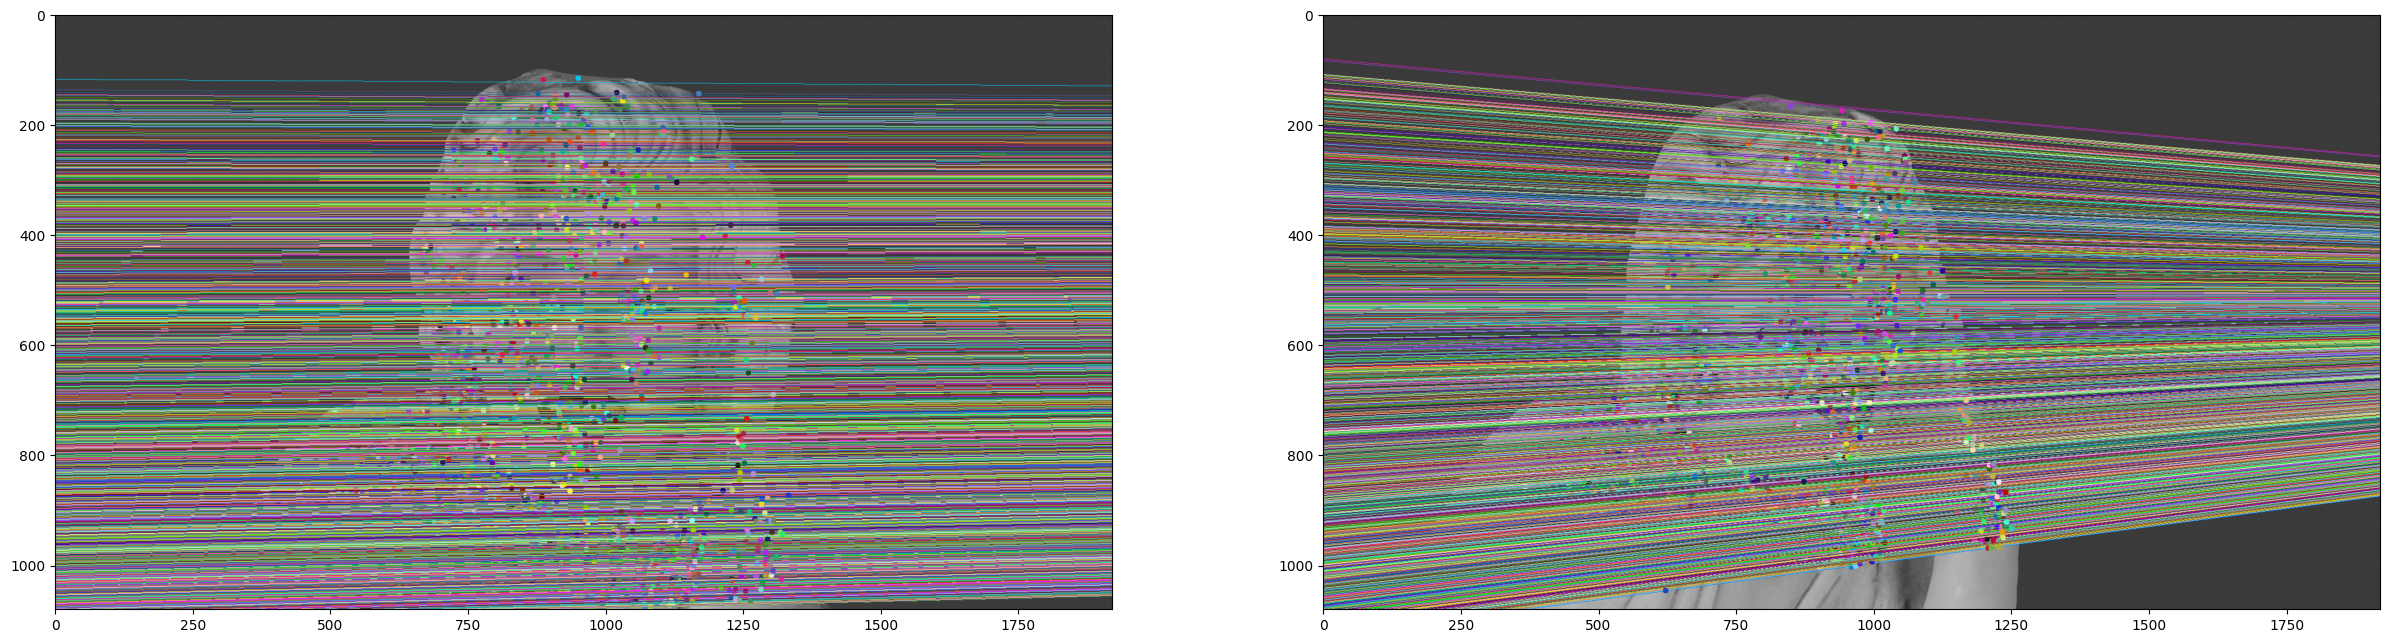

Final number of point matches: 2330


In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from math import sin, cos, radians

# Load and preprocess images
img1 = cv.imread("samples/marilyn_front.png", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("samples/marilyn_left.png", cv.IMREAD_GRAYSCALE)

# kernel = np.array([[0, -1, 0], [-1, 10, -1], [0, -1, 0]]) / 6.0  # normalise if needed


# img1 = cv.filter2D(img1, -1, kernel)
# img2 = cv.filter2D(img2, -1, kernel)

# img1 = cv.GaussianBlur(img1, (5, 5), 1.0)
# img1 = cv.addWeighted(img1, 1.5, img1, -0.5, 0)
# img2 = cv.GaussianBlur(img2, (5, 5), 1.0)
# img2 = cv.addWeighted(img2, 1.5, img2, -0.5, 0)


# Create SIFT detector with custom parameters for more keypoints
sift = cv.SIFT_create(
    nfeatures=0,  # Maximum number of features (0 = unlimited)
    nOctaveLayers=3,
    contrastThreshold=0.002,  # Lower threshold = more keypoints (default is 0.04)
    edgeThreshold=16,  # Higher threshold = more keypoints (default is 10)
    sigma=1.6,
)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

print(f"Keypoints in image 1: {len(kp1)}")
print(f"Keypoints in image 2: {len(kp2)}")

# FLANN parameters - slightly modified for better performance
FLANN_INDEX_KDTREE = 4
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=4)  # Increased from 5
search_params = dict(checks=120)  # Increased from 50

flann = cv.FlannBasedMatcher(index_params, search_params)

# Cross-check matching for better results
matches1to2 = flann.knnMatch(des1, des2, k=2)
matches2to1 = flann.knnMatch(des2, des1, k=2)

# Apply ratio test with a higher threshold (0.85 instead of 0.8)
ratio_thresh = 0.88

# First direction (1 to 2)
good_matches1to2 = []
pts1_temp = []
pts2_temp = []

for i, (m, n) in enumerate(matches1to2):
    if m.distance < ratio_thresh * n.distance:
        good_matches1to2.append(m)
        pts1_temp.append(kp1[m.queryIdx].pt)
        pts2_temp.append(kp2[m.trainIdx].pt)

# Second direction (2 to 1)
good_matches2to1 = []
for i, (m, n) in enumerate(matches2to1):
    if m.distance < ratio_thresh * n.distance:
        good_matches2to1.append(m)

# Optional: Cross-check to keep only matches that appear in both directions
# This is an optional step - sometimes it improves quality but reduces quantity
# Comment this section if you want more matches
"""
pts1 = []
pts2 = []
for match1 in good_matches1to2:
    idx1 = match1.queryIdx
    idx2 = match1.trainIdx
    
    # Check if there's a match in the other direction
    for match2 in good_matches2to1:
        if match2.queryIdx == idx2 and match2.trainIdx == idx1:
            pts1.append(kp1[idx1].pt)
            pts2.append(kp2[idx2].pt)
            break
"""

# If you want more matches, use the non-cross-checked version
pts1 = pts1_temp
pts2 = pts2_temp

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

print(f"Number of matches before RANSAC: {len(pts1)}")

# Use RANSAC with a more lenient threshold to keep more matches
F, mask = cv.findFundamentalMat(
    pts1,
    pts2,
    method=cv.FM_RANSAC,
    ransacReprojThreshold=20.0,  # Default is 3.0, higher = more matches
    confidence=0.99,
)  # Higher confidence = more iterations

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]


# Rest of your code remains the same
def drawlines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2


# Find epilines corresponding to points in right image and drawing lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image and drawing lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.figure(figsize=(30, 18))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

print(f"Final number of point matches: {len(pts1)}")

In [2]:
# original

# %matplotlib qt

# import numpy as np
# import cv2 as cv
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Camera intrinsics
focal_length_mm = 50
sensor_width_mm = 36
image_width_px = 1920
image_height_px = 1080

# Calculate focal length in pixels
focal_length_px = (focal_length_mm / sensor_width_mm) * image_width_px

# Camera intrinsics matrix
K = np.array(
    [
        [focal_length_px, 0, image_width_px / 2],
        [0, focal_length_px, image_height_px / 2],
        [0, 0, 1],
    ]
)

R1 = cv.Rodrigues(np.deg2rad([15, 0, 0]))[0]
t1 = np.array([[0], [0], [-1]])

R2 = cv.Rodrigues(np.deg2rad([-30, 0, 0]))[0]
t2 = np.array([[-0.5], [0], [-1]])

# Projection matrices
P1 = K @ np.hstack((R1, t1))  # Projection matrix for the first camera
P2 = K @ np.hstack((R2, t2))  # Projection matrix for the second camera

# Assuming pts1 and pts2 are your matched points
# Ensure pts1 and pts2 are numpy arrays
pts1 = np.array(pts1, dtype=np.float32)  # 2D points from image 1
pts2 = np.array(pts2, dtype=np.float32)  # 2D points from image 2

# Check for equal lengths
if pts1.shape[0] != pts2.shape[0]:
    raise ValueError("The number of points in pts1 and pts2 must be the same.")

# Convert to homogeneous coordinates
pts1_hom = cv.convertPointsToHomogeneous(pts1).reshape(-1, 3)  # shape (N, 3)
pts2_hom = cv.convertPointsToHomogeneous(pts2).reshape(-1, 3)  # shape (N, 3)

# Triangulation
points_4D = cv.triangulatePoints(
    P1, P2, pts1_hom[:, :2].T, pts2_hom[:, :2].T
)  # shape (4, N)

# Normalize to convert to 3D coordinates
points_3D = points_4D[:3] / points_4D[3]  # Normalize by the last row

# plt.figure(figsize=(10, 7))
# ax = plt.axes(projection="3d")

# # Scatter plot of the 3D points
# ax.scatter(points_3D[0], points_3D[1], points_3D[2], c="b", marker="o", s=4)

# ax.set_xlabel("X Coordinate")
# ax.set_ylabel("Y Coordinate")
# ax.set_zlabel("Z Coordinate")
# ax.set_title("3D Points Reconstruction")

# plt.show()

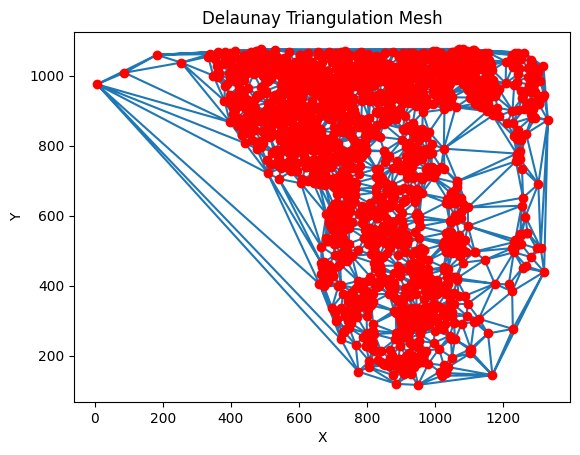

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Example: replace with your actual points (Nx2 array)
points = pts1

# Compute Delaunay triangulation
tri = Delaunay(points)

# Plot result
plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy())
plt.plot(points[:, 0], points[:, 1], "o", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Delaunay Triangulation Mesh")
plt.show()